In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob
import os
sys.path.insert(0,"/home/daqtest/Processor/sandpro")
import sandpro
import configparser
import json

### Check which datasets are available

In [7]:
data_folder = "/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output"
glob.glob(f"{data_folder}/*meta*")

['/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/meta_config_0_2520_20240425_115904.json']

In [74]:
meta_data_list = glob.glob(f"{data_folder}/*meta*")

### Extract the config name, and fing the config in the tmp folder

In [188]:
meta_data = meta_data_list[0]
meta_data_basename = os.path.basename(meta_data)
parts = meta_data_basename.split('_')
config_name = "_".join(parts[1:4]) + ".ini"
threshold_adc = parts[3]
channel = int(parts[2])
print(config_name)

config_1_2520.ini


In [167]:
config_path = os.path.join(data_folder, "tmp",config_name)
config = configparser.ConfigParser()
config.optionxform = str
config.read(config_path)

['/home/daqtest/DAQ/SandyAQ/python_wrappers/notebooks/test_output/tmp/config_1_2520.ini']

### Set the processor config

In [168]:
process_config = {"nchs": 1,
 "nsamps": int(config.get("COMMON", "RECORD_LENGTH")),
 "sample_selection": 120,
 "samples_to_average": 40
}

# dump the config to a json file
with open("process_config.json", "w") as f:
    json.dump(process_config, f)

In [169]:
if len(config.get("BOARD-0", "CHANNEL_LIST")) > 0:
    board_number = 0
else:
    board_number = 1

In [170]:
processor= sandpro.processing.rawdata.RawData(config_file = "process_config.json",
                                               perchannel=False)

In [171]:
data_file_basename = meta_data_basename.replace("meta_", "").replace(".json", f"_board_{board_number}.bin")

In [172]:
data_file_basename

'config_1_2520_20240425_134920_board_0.bin'

In [174]:
data = processor.get_rawdata_numpy(n_evts=820,
                                   file=os.path.join(data_folder, data_file_basename),
                                   bit_of_daq=14,
                                   headersize=4,inversion=False)

Text(0.5, 1.0, 'channel 1')

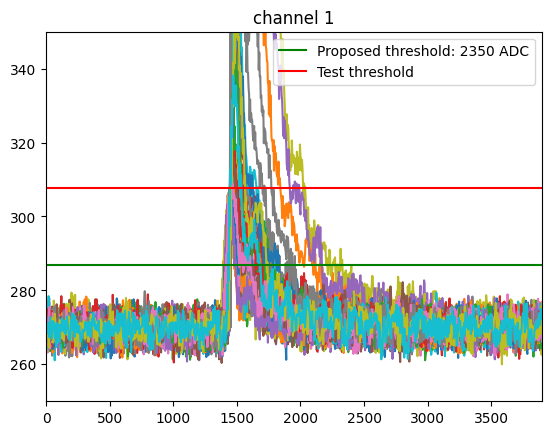

In [194]:
threshold_mv = float(threshold_adc) * (2/2**14.) * 1000.
optimal_threshold_adc = 2350
optimal_threshold_mv = float(optimal_threshold_adc) * (2/2**14.) * 1000.

time = np.arange(0, process_config["nsamps"], 1) * 4
for i in range(750,800):
    plt.plot(time, data["data_per_channel"][i][0])
plt.axhline(optimal_threshold_mv, color='g',label=f"Proposed threshold: {optimal_threshold_adc} ADC")
plt.axhline(threshold_mv, color='r',label="Test threshold")
plt.ylim(250,350)
plt.xlim(0,3900)
plt.legend()
plt.title(f"channel {channel}")

SyntaxError: invalid syntax (2447616204.py, line 1)

In [196]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff=1e6, fs=250e6, order=1):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

class WFProcessor(object):
    def __init__(self,data_folder,length_per_event=1000,volt_per_adc=1/4096,polarity=True):
        self.data_folder = data_folder
        self.length_per_event = length_per_event
        self.volt_per_adc = volt_per_adc
        self.polarity = polarity
        self.wfs = None

    def set_data(self,data):
        """
        Load data from a numpy array
        """
        self.wfs = data
        self.event_number = len(self.wfs)
        self.time = np.arange(0, self.length_per_event, 1) * 4

    def process_wfs(self,baseline_front=(0.1,0.3),baseline_back=(0.7,0.9),cutoff=10e6,fs=250e6):
        baseline_start_f = int(self.length_per_event * baseline_front[0])
        baseline_end_f = int(self.length_per_event * baseline_front[1])
        baseline_start_b = int(self.length_per_event * baseline_back[0])
        baseline_end_b = int(self.length_per_event * baseline_back[1])
        self.baseline = (np.mean(self.wfs[:,baseline_start_f:baseline_end_f],axis=1) + np.mean(self.wfs[:,baseline_start_b:baseline_end_b],axis=1))/2
        self.baseline_rms = np.std(self.wfs[:,baseline_start_f:baseline_end_f],axis=1)
        baseline = self.baseline.repeat(self.length_per_event).reshape(self.event_number,self.length_per_event)
        self.processed_wfs = (self.wfs - baseline)*self.volt_per_adc
        self.filtered_wfs = butter_lowpass_filter(self.processed_wfs,cutoff,fs)

    def plot_single_wf(self,i,filtered=True):
        plt.figure(figsize=(10,3))
        if filtered:
            plt.plot(self.time,self.filtered_wfs[i])
            plt.xlabel("Time [ns]")
            plt.ylabel("Voltage [V]")
            plt.xticks(np.arange(0, 4000, step=200))
            plt.ylim(-0.01,0.02)
            plt.xlim(0,3950)
        else:
            plt.plot(self.wfs[i])
            plt.xlabel("Sample index")
            plt.ylabel("ADC counts")
            plt.xticks(np.arange(0, 1000, step=100))
            #plt.show()
            plt.xlim(0,1000)

    def plot_random_wfs(self,n,filtered=True,random_seed=None):
        if random_seed:
            np.random.seed(random_seed)
        for i in np.random.choice(self.event_number,n):
            self.plot_single_wf(i,filtered)

    def plot_average_wfs(self,filtered=True, scaling=1,color="red",show_distribution = None,label=None):
        plt.figure(figsize=(10,3))

        if filtered:
            reference_wfs = self.filtered_wfs
        else:
            reference_wfs = self.wfs
        averaged_wfs = np.mean(reference_wfs,axis=0)

        plt.plot(self.time,averaged_wfs * scaling,color=color,label=label)

        if show_distribution:
            plt.fill_between(self.time,scaling * np.percentile(reference_wfs, 25, axis=0),scaling * np.percentile(reference_wfs, 75, axis=0),
            step='mid', alpha=0.3, color=color, linewidth=0)
            #show_index = np.random.choice(np.arange(len(reference_wfs)),show_distribution)
            #distance_list = np.max(np.abs(reference_wfs[show_index] - averaged_wfs),axis=1)
            #print(len(distance_list))
            #max_distance = np.max(distance_list)
            #for index in show_index:
                #plt.plot(self.time, reference_wfs[index] * scaling,alpha = 0.5 * (1 - (np.max(np.abs(reference_wfs[index]-averaged_wfs))/max_distance)),color=color)

        plt.xlabel("Time [ns]")
        plt.ylabel("Voltage [V]")
        plt.xticks(np.arange(1800, 2200, step=20))
        plt.xlim(1800,2200)

    def get_area(self,sum_window=(0.4,0.6)):
        sum_start = int(self.length_per_event * sum_window[0])
        sum_end = int(self.length_per_event * sum_window[1])
        self.areas = np.sum(self.filtered_wfs[:,sum_start:sum_end],axis=1) # unit: mV
        self.areas *= 4 # now it becomes mV * ns
        if not self.polarity:
            self.areas = -self.areas
        return self.areas

In [199]:
wfp = WFProcessor(data_folder, volt_per_adc=2/2**14)
wfp.set_data(data["data_per_channel"][1500:1900,0])

In [200]:
wfp.process_wfs()
wfp.plot_random_wfs(5,filtered=True)

ValueError: a must be greater than 0 unless no samples are taken

In [162]:
areas = wfp.get_area(sum_window=(0.3,0.4))

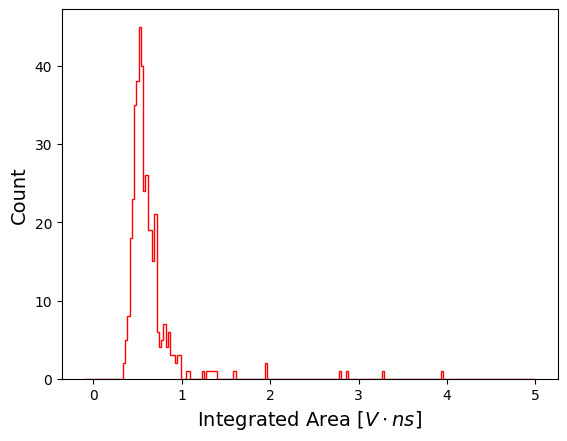

In [163]:
plt.hist(areas,bins=200,range=(-0.1,5),histtype='step',color='red',label="Channel 0")
plt.ylabel("Count",fontsize=14)
plt.xlabel("Integrated Area [$V\cdot ns$]",fontsize=14)
#plt.ylim(0,100)
plt.show()